In [25]:
import numpy as np
import cv2
import os
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import math
import open3d as o3d
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor
from sklearn.cluster import KMeans
from scipy.optimize import minimize
from pathlib import Path


In [6]:
def calculate_normal_vector(points):
    pca = PCA(n_components=3)
    pca.fit(points)
    normal_vector = pca.components_[-1]  # The normal vector is the eigenvector with the smallest eigenvalue

    normal_vector = np.array(normal_vector)
    angle_with_x_axis = np.arccos(np.dot(normal_vector, [1, 0, 0]))
    angle_with_y_axis = np.arccos(np.dot(normal_vector, [0, 1, 0]))
    angle_with_z_axis = np.arccos(np.dot(normal_vector, [0, 0, 1]))
    normal_vector = [angle_with_x_axis, angle_with_y_axis, angle_with_z_axis]
    # print(normal_vector)
    return normal_vector

def angle_with_z_axis(vector):
    vector = vector / np.linalg.norm(vector)
    return np.arccos(np.dot(vector, [0, 0, -1]))

In [5]:
def xy2radius(x, y):
    return math.sqrt(x**2 + y**2)

def xy2theta(x, y):
    return math.atan2(y, x)

In [7]:
def apply_gabor_filter(image, ksize=13, sigma=1, theta=0, lambd=7, gamma=0.5):
    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma)
    return cv2.filter2D(image, cv2.CV_32F, kernel)

def cluster_images(images, n_clusters):
    flattened_images = [img.flatten() for img in images]
    kmeans = KMeans(n_clusters=n_clusters).fit(flattened_images)
    return kmeans.labels_, kmeans.cluster_centers_

In [286]:
class Zone:
    def __init__(self):
        self.points = []

class CZM:
    def __init__(self, pcd_file_path):
        self.pcd_file_path = pcd_file_path
        self.point_cloud = None

        # Define range parameters
        self.min_range_ = 4
        self.min_range_z2_ = 12
        self.min_range_z3_ = 28
        self.min_range_z4_ = 60
        self.max_range_ = 100.0
        self.min_ranges_ = [self.min_range_, self.min_range_z2_, self.min_range_z3_, self.min_range_z4_]

        # Define zone, sector, and ring parameters
        self.num_zones = 4
        self.num_sectors_each_zone = [72, 48, 48, 64]
        self.num_rings_each_zone = [4, 4, 5, 5]
        self.ring_sizes_ = [
            (self.min_range_z2_ - self.min_range_) / self.num_rings_each_zone[0],
            (self.min_range_z3_ - self.min_range_z2_) / self.num_rings_each_zone[1],
            (self.min_range_z4_ - self.min_range_z3_) / self.num_rings_each_zone[2],
            (self.max_range_ - self.min_range_z4_) / self.num_rings_each_zone[3]
        ]
        self.sector_sizes_ = [
            2 * math.pi / self.num_sectors_each_zone[0],
            2 * math.pi / self.num_sectors_each_zone[1],
            2 * math.pi / self.num_sectors_each_zone[2],
            2 * math.pi / self.num_sectors_each_zone[3]
        ]
        
        self.images_to_cluster = []
        self.labels = []
        self.max_stripes_list = []

        # Load point cloud
        self.load_point_cloud()
        
    def load_point_cloud(self):
        pcd = o3d.io.read_point_cloud(self.pcd_file_path)
        all_points = np.asarray(pcd.points)
        z_values = [pt[2] for pt in all_points]
        min_z = min(z_values)
        max_z = max(z_values)
        
        # 해당 값을 나중에 다른 메서드에서 사용하기 위해 인스턴스 변수로 저장
        self.point_cloud = all_points
        self.min_z = min_z
        self.max_z = max_z
        print(min_z, max_z)

        # 원본 포인트 클라우드를 시각화
        # o3d.visualization.draw_geometries([pcd])
        
    def calculate_normal_vector(self, points):
        pca = PCA(n_components=3)
        pca.fit(points)
        normal_vector = pca.components_[-1]

        normal_vector = np.array(normal_vector)
        angle_with_x_axis = np.arccos(np.dot(normal_vector, [1, 0, 0]))
        angle_with_y_axis = np.arccos(np.dot(normal_vector, [0, 1, 0]))
        angle_with_z_axis = np.arccos(np.dot(normal_vector, [0, 0, 1]))
        normal_vector = [angle_with_x_axis, angle_with_y_axis, angle_with_z_axis]
        # print(normal_vector)
        return normal_vector

    def angle_with_z_axis(self, vector):
        vector = vector / np.linalg.norm(vector)
        return np.arccos(np.dot(vector, [0, 0, -1]))

    # def apply_gabor_filter(self, image, ksize=7, sigma=1, theta=0, lambd=7, gamma=0.5):
    #     kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma)
    #     # return cv2.filter2D(image, cv2.CV_32F, kernel)
    #     return cv2.filter2D(image, -1, kernel)
        
    def apply_gabor_filter(self,image, angle):
        ksize = 15
        sigma = 5
        lambd = 3
        gamma = 0.5
        psi = 0  # phase offset
        theta = angle * np.pi / 8

        gabor_filter = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi)
        
        filtered_image = cv2.filter2D(image, cv2.CV_8UC3, gabor_filter)

        # 임계값 설정 및 스트라이프 영역 검출
        threshold = np.max(filtered_image) * 0.9
        stripe_regions = filtered_image > threshold
        stripe_image = np.uint8(stripe_regions * 255)

        return stripe_image
        # return filtered_image

    def count_stripes(self,image, min_length=5):
        contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        count = 0
        for contour in contours:
            length = cv2.arcLength(contour, True) # 외곽선의 길이 계산
            if length > min_length: # 길이가 임계값보다 크면 카운트
                count += 1
        return count

    # def extract_features(self, image):
    #     features = []

    #     for angle in range(8):
    #         filtered_image = self.apply_gabor_filter(image, angle)
    #         features.append(np.mean(filtered_image))
    #         features.append(np.std(filtered_image))
    #     return features

    def extract_features(self, image, image_sector_index):
        max_stripes = 0
        best_image = None

        for angle in range(8):
            filtered_image = self.apply_gabor_filter(image, angle)
            num_stripes = self.count_stripes(filtered_image)
            if num_stripes > max_stripes:
                max_stripes = num_stripes
                best_image = filtered_image

        if best_image is not None:
            # print(max_stripes)
            
            self.images_to_cluster.append(best_image.flatten())
            self.labels.append(image_sector_index)
            self.max_stripes_list.append(max_stripes)
        else :
            best_image = np.zeros((15, 15), dtype=np.uint8)
            self.images_to_cluster.append(best_image.flatten())
            self.labels.append(image_sector_index)
            self.max_stripes_list.append(max_stripes)

    def remove_specific_pattern(self, image, threshold):
        # 패딩 추가 (상, 하, 좌, 우 1픽셀씩)
        padded_image = np.pad(image, pad_width=1, mode='constant', constant_values=0)

        # 원래 이미지와 패딩된 이미지의 차이 계산 (상하좌우)
        diff_up = padded_image[:-2, 1:-1] - padded_image[1:-1, 1:-1]
        diff_down = padded_image[2:, 1:-1] - padded_image[1:-1, 1:-1]
        diff_left = padded_image[1:-1, :-2] - padded_image[1:-1, 1:-1]
        diff_right = padded_image[1:-1, 2:] - padded_image[1:-1, 1:-1]

        # 조건에 맞는 픽셀 찾기 (상하좌우 차이가 모두 threshold보다 큰 경우)
        condition = (diff_up > threshold) & (diff_down > threshold) & (diff_left > threshold) & (diff_right > threshold)

        # 조건에 맞는 픽셀을 0으로 설정
        result_image = np.copy(image)
        result_image[condition] = 0

        return result_image

    # def count_stripes(self, image, theta):
    #     filtered_image = self.apply_gabor_filter(image, ksize=13, sigma=1, theta=theta, lambd=7, gamma=0.5)
    #     local_maxima = (filtered_image == cv2.dilate(filtered_image, np.ones((3,3))))
    #     return np.sum(local_maxima)
    # def count_stripes(self, image, theta):
    #     filtered_image = self.apply_gabor_filter(image, ksize=15, sigma=15, theta=theta, lambd=2, gamma=1)
    #     local_maxima = (filtered_image == cv2.dilate(filtered_image, np.ones((3,3))))
    #     total_stripes = np.sum(local_maxima)
    #     if total_stripes == 0:
    #         return 0, None  # 또는 적절한 이미지로 대체 가능합니다.
    #     return total_stripes, filtered_image


    # def count_stripes(self, image, theta):
    #     ksizes = [3, 5, 7, 9, 11, 13]
    #     lambdas = [0.1,0.5,1,3,5,7,9]
    #     thetas = [np.pi * i / 4 for i in range(8)]
    #     total_stripes_all = []

    #     for ksize in ksizes:
    #         for lambd in lambdas:
    #             for theta in thetas:
    #                 filtered_image = self.apply_gabor_filter(image, ksize=ksize, sigma=15, theta=theta, lambd=lambd, gamma=1)
    #                 local_maxima = (filtered_image == cv2.dilate(filtered_image, np.ones((3,3))))
    #                 total_stripes = np.sum(local_maxima)
    #                 total_stripes_all.append(total_stripes)

    #     if all(stripe == 0 for stripe in total_stripes_all):
    #         return 0, None
    #     return total_stripes_all, filtered_image


    # def analyze_cluster(self, cluster_images):
    #     thetas = [np.pi * i / 4 for i in range(8)]
    #     stripe_counts = [np.mean([self.count_stripes(img, theta=t) for t in thetas]) for img in cluster_images]
    #     return np.mean(stripe_counts)

    def analyze_cluster(self, labels, cluster_label):
        cluster_stripes = [stripe for idx, stripe in enumerate(self.max_stripes_list) if labels[idx] == cluster_label]
        if cluster_stripes:
            mean_stripe_count = np.mean(cluster_stripes)
        else:
            mean_stripe_count = 0
        return mean_stripe_count


    def segment_czm(self):
        ring_sizes_ = [(self.min_range_z2_ - self.min_range_) / self.num_rings_each_zone[0],
                    (self.min_range_z3_ - self.min_range_z2_) / self.num_rings_each_zone[1],
                    (self.min_range_z4_ - self.min_range_z3_) / self.num_rings_each_zone[2],
                    (self.max_range_ - self.min_range_z4_) / self.num_rings_each_zone[3]]

        sector_sizes_ = [2 * math.pi / self.num_sectors_each_zone[0], 
                        2 * math.pi / self.num_sectors_each_zone[1], 
                        2 * math.pi / self.num_sectors_each_zone[2], 
                        2 * math.pi / self.num_sectors_each_zone[3]]

        sector_indices = [] 

        czm = [[
            [Zone() for _ in range(self.num_sectors_each_zone[zone_idx])]
            for _ in range(self.num_rings_each_zone[zone_idx])
        ] for zone_idx in range(self.num_zones)]

        for pt in self.point_cloud:
            x, y, z = pt
            r = xy2radius(x, y)
            if r <= self.max_range_ and r > self.min_range_:
                theta = xy2theta(x, y)
                zone_idx = ring_idx = sector_idx = 0

                if r < self.min_range_z2_:
                    zone_idx = 0
                    ring_idx = min(int((r - self.min_range_) / ring_sizes_[0]), self.num_rings_each_zone[0]-1)
                    sector_idx = min(int(theta / sector_sizes_[0]), self.num_sectors_each_zone[0]-1)
                    czm[zone_idx][ring_idx][sector_idx].points.append([x, y, z])
                elif r < self.min_range_z3_:
                    zone_idx = 1
                    ring_idx = min(int((r - self.min_range_z2_) / ring_sizes_[1]), self.num_rings_each_zone[1]-1)
                    sector_idx = min(int(theta / sector_sizes_[1]), self.num_sectors_each_zone[1]-1)
                    czm[zone_idx][ring_idx][sector_idx].points.append([x, y, z])
                elif r < self.min_range_z4_:
                    zone_idx = 2
                    ring_idx = min(int((r - self.min_range_z3_) / ring_sizes_[2]), self.num_rings_each_zone[2]-1)
                    sector_idx = min(int(theta / sector_sizes_[2]), self.num_sectors_each_zone[2]-1)
                    czm[zone_idx][ring_idx][sector_idx].points.append([x, y, z])
                else:
                    zone_idx = 3
                    ring_idx = min(int((r - self.min_range_z4_) / ring_sizes_[3]), self.num_rings_each_zone[3]-1)
                    sector_idx = min(int(theta / sector_sizes_[3]), self.num_sectors_each_zone[3]-1)
                    czm[zone_idx][ring_idx][sector_idx].points.append([x, y, z])
                    
                czm[zone_idx][ring_idx][sector_idx].points.append([x, y, z])
                sector_indices.append((zone_idx, ring_idx, sector_idx)) # 인덱스 추가
        return czm, sector_indices
        #sector_indices 는 각 포인트마다 몇 번째 섹터에 속하는지 나타냄. 

    def process_sectors(self, sectors, img_dim=15, MIN_POINTS=10, MAX_Z_DIFF=0.8): # MAX_Z_DIFF 파라미터 추가
        images = []
        traversable_points = []
        all_image_vectors = []
        image_sector_indices = []

        for zone_idx, layer in enumerate(sectors):
            for ring_idx, ring in enumerate(layer):
                for sector_idx, sector in enumerate(ring):
                    if len(sector.points) > MIN_POINTS:
                        points = np.array([pt[:3] for pt in sector.points])
                        normal_vector = calculate_normal_vector(points)

                        sector_center_x = np.mean(points[:, 0])
                        sector_center_y = np.mean(points[:, 1])
                        sector_center_z = np.mean(points[:, 2])

                        z_values = [pt[2] for pt in sector.points]
                        min_z, max_z = min(z_values), max(z_values)

                        # z 좌표의 최대값과 최소값의 차이가 일정 이하인 경우만 처리
                        if angle_with_z_axis(normal_vector) >= 1.1 and angle_with_z_axis(normal_vector) <= 1.9 and (max_z - min_z) <= MAX_Z_DIFF:
                            traversable_points.extend(points)
                            image = np.zeros((img_dim, img_dim), dtype=np.uint8)

                            x_values = [pt[0] for pt in sector.points]
                            y_values = [pt[1] for pt in sector.points]

                            min_x, max_x = min(x_values), max(x_values)
                            min_y, max_y = min(y_values), max(y_values)

                            for pt in sector.points:
                                normalized_x = int((pt[0] - min_x) / (max_x - min_x) * (img_dim - 1))
                                normalized_y = int((pt[1] - min_y) / (max_y - min_y) * (img_dim - 1))
                                normalized_z = int((pt[2] - min_z) / (max_z - min_z) * 255)

                                image[normalized_y, normalized_x] = normalized_z

                            image_2d = image.reshape(img_dim, img_dim)
                            image_2d = self.remove_specific_pattern(image_2d,15)

                            images.append(image_2d)
                            image_sector_indices.append((zone_idx, ring_idx, sector_idx)) # 해당 이미지의 sector 인덱스 추가

                            image_vector = image_2d.reshape(-1, 1)
                            all_image_vectors.append(image_vector)

        return images, image_sector_indices

    def visualize_clusters(self, images, sector_indices, n_clusters, base_output_folder):
        for img, sector_index in zip(images, sector_indices):
            self.extract_features(img, sector_index)
        print("length of images :", len(images))     
        print("length of mst : " , len(self.max_stripes_list))  
        print(self.max_stripes_list)

        kmeans = KMeans(n_clusters=n_clusters).fit(np.array(self.max_stripes_list).reshape(-1, 1))
        # kmeans = KMeans(n_clusters=n_clusters).fit(X)
        # stripe_counts = [self.analyze_cluster([img])[0] for img in images]

        sector_cluster_mapping = {}

        # Save images to clusters
        for i, label in enumerate(kmeans.labels_):
            max_stripes = self.max_stripes_list[i]
            best_image = self.images_to_cluster[i].reshape(images[i].shape)
            combined_image = np.hstack((images[i], best_image))

            cluster_path = os.path.join(base_output_folder, f"cluster_{label}")
            save_path = os.path.join(cluster_path, f"{label}_stripes_{max_stripes}_{i}.png")  # 파일 이름에 max_stripes 추가
            if not os.path.exists(cluster_path):
                os.makedirs(cluster_path)
            # cv2.imwrite(os.path.join(cluster_path, f"image_{i}.png"), images[i])
            # cv2.imwrite(save_path, combined_image)

            # Map sector indices to clusters
            sector_index = sector_indices[i]
            sector_cluster_mapping[sector_index] = label

        # Analyze clusters
        cluster_stripe_counts = {}
        for i in range(n_clusters):
            cluster_images = [img for idx, img in enumerate(images) if kmeans.labels_[idx] == i]
            cluster_stripe_counts = {i: self.analyze_cluster(kmeans.labels_, i) for i in range(n_clusters)}

        # Sort clusters by mean stripe count
        sorted_clusters = sorted(cluster_stripe_counts.items(), key=lambda x: x[1], reverse=True)
        print(sorted_clusters)

        # Visualize clusters
        for cluster_index, _ in sorted_clusters:
            cluster_path = os.path.join(base_output_folder, f"cluster_{cluster_index}")
            image_files = [os.path.join(cluster_path, f) for f in os.listdir(cluster_path) if os.path.isfile(os.path.join(cluster_path, f))]
            images = [cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in image_files]

            # plt.figure(figsize=(10, 10))
            # for idx, img in enumerate(images[:16]): # Displaying the first 16 images from each cluster
            #     plt.subplot(4, 4, idx + 1)
            #     plt.imshow(img, cmap='gray')
            #     plt.axis('off')

            # plt.suptitle(f"Cluster {cluster_index}")
            # plt.show()
        # print("Clusters have been visualized by stripe pattern repetition.")

        # for i in range(n_clusters):
        #     cluster_images = [img for idx, img in enumerate(images) if kmeans.labels_[idx] == i]
        #     # cluster_stripe_count_mean = self.analyze_cluster(cluster_images)
        #     print(f"Cluster {i} Mean Stripe Count: {cluster_stripe_count_mean}")

        #     # # Show only first 5 Gabor-filtered images per cluster
        #     # for idx, gabor_image in enumerate(gabor_images[:5]):
        #     #     plt.imshow(gabor_image, cmap='gray')
        #     #     plt.title(f'Cluster {i} Gabor Image {idx}')
        #     #     plt.show()
        return sorted_clusters, sector_cluster_mapping

    def calculate_cluster_z_variance(self, sectors, sector_cluster_mapping):
        cluster_z_variances = {}
        cluster_z_variance_means = {}  # 클러스터별 z 분산의 평균을 저장할 딕셔너리
        cluster_residuals = {}
        cluster_residual_means = {}

        # 클러스터별 z 값 분산을 계산
        for zone_idx, zone in enumerate(sectors):
            for ring_idx, ring in enumerate(zone):
                for sector_idx, sector in enumerate(ring):
                    cluster_label = sector_cluster_mapping.get((zone_idx, ring_idx, sector_idx))
                    if cluster_label is not None:
                        xy_values = [pt[:2] for pt in sector.points]
                        z_values = [pt[2] for pt in sector.points]

                        # RANSAC을 사용하여 대표 평면 찾기
                        ransac = RANSACRegressor()
                        ransac.fit(xy_values, z_values)
                        predicted_z = ransac.predict(xy_values)

                        # 각 포인트와 대표 평면 사이의 residual 계산
                        residuals = np.abs(predicted_z - z_values)

                        z_variance = np.var(z_values)

                        if cluster_label not in cluster_residuals:
                            cluster_residuals[cluster_label] = []

                        if cluster_label not in cluster_z_variances:
                            cluster_z_variances[cluster_label] = []

                        cluster_z_variances[cluster_label].append(z_variance)

                        cluster_residuals[cluster_label].extend(residuals)


        # 클러스터별로 그래프 그리기 및 residual 평균 계산
        for cluster_label, residuals in cluster_residuals.items():
            # 클러스터별 residual 평균 계산
            cluster_residual_means[cluster_label] = np.mean(residuals)

            # # 시각화를 위해 그래프 그리기
            # plt.figure(figsize=(10, 4))
            # plt.bar(range(len(residuals)), residuals)
            # plt.xlabel('Sector')
            # plt.ylabel('Residual')
            # plt.title(f'Cluster {cluster_label} - Residuals by Sector')
            # plt.show()

        cluster_residual_means = sorted(cluster_residual_means.items(), key=lambda x: x[1])


        # 클러스터별로 그래프 그리기
        for cluster_label, variances in cluster_z_variances.items():
        
            # Removing outliers
            Q1 = np.percentile(variances, 10)
            Q3 = np.percentile(variances, 90)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            filtered_variances = [v for v in variances if v >= lower_bound and v <= upper_bound]

            # plt.figure(figsize=(10, 4))
            # plt.bar(range(len(filtered_variances)), filtered_variances)
            # plt.xlabel('Sector')
            # plt.ylabel('Z Variance')
            # plt.title(f'Cluster {cluster_label} - Z Variance by Sector (Outliers Removed)')
            # plt.show()

            # 클러스터별 z 분산의 평균 계산
            cluster_z_variance_means[cluster_label] = np.mean(filtered_variances)

        cluster_z_variance_means = sorted(cluster_z_variance_means.items(), key=lambda x: x[1])

        print(cluster_residual_means)
        print(cluster_z_variance_means)
        return cluster_z_variance_means, cluster_residual_means


In [287]:
pcd_file_path = "/media/rtlink/JetsonSSD-256/Download/Rellis_3D_os1_cloud_node_color_ply/Rellis-3D/00000/os1_cloud_node_color_ply/pcd_files/frame001896-1581624842_364.pcd"
czm = CZM(pcd_file_path) # Zone 대신 CZM 클래스를 사용

-1.6572240591049194 5.804795742034912


In [288]:
sectors, sector_indices = czm.segment_czm() # 인스턴스 czm을 통해 메서드를 호출하고, sector_indices도 받습니다.

In [289]:
images, image_sector_indices = czm.process_sectors(sectors) # 인스턴스 czm을 통해 메서드를 호출하고, image_sector_indices도 받습니다.

In [290]:
sorted_clusters, sector_cluster_mapping = czm.visualize_clusters(images, image_sector_indices, n_clusters=3, base_output_folder='output_clusters') # 인스턴스 czm을 통해 메서드를 호출

length of images : 29
length of mst :  29
[6, 5, 7, 5, 8, 8, 6, 8, 6, 5, 6, 7, 7, 4, 5, 2, 5, 8, 6, 7, 3, 6, 7, 1, 5, 5, 4, 5, 1]
[(2, 7.444444444444445), (0, 5.25), (1, 1.75)]


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [291]:
mean_cluster_z_variances, cluster_residual_means = czm.calculate_cluster_z_variance(sectors, sector_cluster_mapping)

[(2, 0.017291133221808943), (0, 0.020271591925245993), (1, 0.05134390339871621)]
[(2, 0.0011475111735187022), (0, 0.0020327932502873865), (1, 0.023261160205678658)]


-2.383615493774414 6.761868000030518
length of images : 17
length of mst :  17
[3, 6, 9, 3, 7, 6, 6, 4, 5, 7, 7, 6, 9, 3, 5, 6, 2]
[(1, 9.0), (0, 6.1), (2, 3.0)]
[(1, 0.0005381917081214545), (0, 0.0018443671703626883), (2, 0.003989699841962877)]
[1, 0, 2]
[1, 0, 2]
-2.495469331741333 7.282830715179443


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 44
length of mst :  44
[7, 7, 6, 6, 6, 6, 7, 7, 5, 6, 5, 5, 6, 5, 5, 4, 5, 7, 6, 6, 7, 4, 7, 7, 6, 6, 5, 6, 6, 6, 5, 6, 6, 7, 3, 8, 4, 5, 5, 7, 4, 7, 6, 3]
[(2, 7.083333333333333), (0, 5.615384615384615), (1, 3.6666666666666665)]
[(2, 0.0011019100334224467), (0, 0.002277702733388997), (1, 0.019936472834647122)]
[2, 0, 1]
[2, 0, 1]
-3.5213091373443604 7.311774730682373


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 190
length of mst :  190
[6, 6, 7, 5, 4, 5, 8, 7, 7, 8, 5, 5, 4, 4, 7, 2, 5, 4, 4, 6, 4, 7, 7, 5, 5, 7, 6, 6, 4, 5, 7, 5, 5, 6, 7, 5, 4, 5, 6, 5, 4, 5, 3, 6, 2, 7, 4, 4, 6, 5, 6, 6, 5, 5, 5, 5, 8, 5, 4, 5, 6, 5, 6, 8, 8, 6, 6, 6, 7, 8, 7, 5, 7, 6, 6, 6, 4, 7, 4, 6, 5, 5, 5, 6, 6, 7, 5, 6, 6, 7, 7, 5, 5, 5, 6, 5, 6, 7, 8, 6, 5, 5, 5, 6, 6, 4, 3, 7, 6, 6, 6, 6, 6, 3, 4, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 8, 6, 5, 6, 5, 6, 6, 9, 5, 6, 6, 6, 6, 9, 5, 4, 3, 5, 4, 5, 7, 7, 3, 3, 6, 1, 6, 6, 5, 5, 8, 5, 6, 3, 4, 5, 4, 6, 6, 4, 6, 6, 6, 5, 3, 5, 3, 4, 4, 3, 5, 4, 5, 7, 3, 4, 7, 5, 3, 1, 1, 3, 3, 3]
[(2, 7.382352941176471), (0, 5.4774774774774775), (1, 3.3777777777777778)]
[(2, 0.0006310881316838135), (0, 0.001812468207364933), (1, 0.003437316738605002)]
[2, 0, 1]
[2, 0, 1]
-3.0920188426971436 7.2586164474487305


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 162
length of mst :  162
[7, 7, 5, 8, 6, 6, 3, 5, 7, 9, 6, 6, 5, 5, 5, 5, 7, 4, 4, 4, 1, 6, 5, 6, 7, 4, 3, 4, 5, 5, 7, 5, 5, 5, 5, 5, 6, 8, 6, 7, 8, 7, 7, 6, 7, 4, 7, 7, 8, 6, 5, 6, 3, 6, 2, 5, 5, 6, 6, 6, 8, 7, 6, 6, 6, 6, 6, 5, 6, 5, 6, 6, 5, 5, 8, 6, 2, 4, 1, 5, 7, 6, 4, 8, 2, 2, 5, 4, 7, 6, 4, 7, 6, 6, 5, 6, 5, 3, 4, 7, 5, 5, 7, 4, 6, 6, 6, 6, 5, 7, 4, 6, 7, 6, 7, 8, 6, 6, 5, 6, 6, 5, 5, 5, 5, 7, 1, 3, 5, 5, 6, 4, 6, 6, 6, 3, 5, 5, 3, 6, 3, 4, 5, 5, 6, 3, 3, 3, 5, 3, 3, 6, 4, 4, 3, 4, 4, 3, 4, 1, 3, 3]
[(0, 6.532467532467533), (1, 4.666666666666667), (2, 2.52)]
[(0, 0.0015183454739827113), (1, 0.0022899708727316796), (2, 0.00662408710221099)]
[0, 1, 2]
[0, 1, 2]
-2.370836019515991 6.761456489562988


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 62
length of mst :  62
[6, 6, 5, 6, 6, 6, 7, 6, 8, 0, 1, 6, 6, 6, 6, 5, 4, 0, 6, 5, 9, 6, 7, 6, 5, 3, 2, 6, 6, 6, 6, 6, 6, 5, 4, 6, 5, 5, 5, 3, 5, 6, 2, 7, 6, 4, 1, 5, 6, 5, 4, 4, 3, 0, 5, 2, 2, 5, 2, 3, 4, 5]
[(2, 6.285714285714286), (0, 4.7), (1, 1.7142857142857142)]
[(2, 0.0012921316920394689), (0, 0.009380534881521642), (1, 0.02837313771011014)]
[2, 0, 1]
[2, 0, 1]
-2.475435256958008 6.093881130218506


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 105
length of mst :  105
[7, 7, 7, 6, 7, 5, 4, 6, 5, 6, 6, 7, 6, 3, 4, 4, 4, 6, 6, 6, 6, 0, 6, 5, 5, 4, 5, 7, 9, 2, 4, 4, 5, 6, 3, 5, 1, 6, 2, 1, 3, 6, 5, 5, 5, 5, 5, 4, 4, 3, 4, 4, 7, 5, 4, 1, 0, 6, 4, 3, 4, 6, 4, 7, 8, 6, 5, 5, 4, 6, 3, 6, 5, 9, 5, 6, 7, 8, 5, 5, 6, 5, 3, 5, 7, 5, 8, 3, 4, 6, 4, 3, 6, 2, 5, 2, 6, 3, 3, 4, 4, 3, 2, 5, 3]
[(2, 6.578947368421052), (0, 4.545454545454546), (1, 2.260869565217391)]
[(2, 0.001606707799576073), (0, 0.0023657400183274414), (1, 0.005822426497597832)]
[2, 0, 1]
[2, 0, 1]
-3.5957019329071045 11.925247192382812


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 90
length of mst :  90
[8, 5, 4, 7, 7, 5, 4, 3, 2, 6, 7, 7, 8, 7, 9, 7, 3, 4, 5, 6, 7, 7, 7, 8, 7, 5, 7, 6, 5, 5, 5, 6, 3, 5, 6, 6, 8, 5, 6, 7, 5, 4, 6, 6, 3, 6, 6, 6, 6, 6, 6, 3, 4, 5, 3, 4, 5, 7, 5, 3, 3, 4, 4, 3, 3, 4, 5, 1, 5, 4, 6, 4, 3, 5, 4, 5, 1, 4, 5, 3, 3, 7, 3, 4, 3, 5, 5, 5, 5, 3]
[(2, 7.315789473684211), (1, 5.421052631578948), (0, 3.272727272727273)]
[(2, 0.0026819985513954225), (0, 0.003251639791735727), (1, 0.005808799199004828)]
[2, 1, 0]
[2, 0, 1]
-2.7190072536468506 8.775931358337402


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 92
length of mst :  92
[6, 5, 4, 6, 7, 5, 6, 4, 5, 5, 7, 6, 5, 7, 6, 4, 5, 0, 6, 5, 8, 3, 8, 6, 7, 3, 2, 3, 5, 2, 6, 7, 3, 1, 0, 6, 5, 7, 6, 4, 3, 4, 4, 4, 7, 4, 4, 4, 3, 3, 7, 4, 4, 6, 7, 8, 5, 7, 5, 4, 7, 5, 5, 5, 5, 3, 5, 6, 1, 4, 6, 5, 5, 8, 4, 4, 3, 4, 3, 3, 4, 1, 5, 2, 2, 4, 4, 4, 3, 1, 1, 3]
[(2, 6.678571428571429), (0, 4.113207547169812), (1, 1.1818181818181819)]
[(2, 0.001932562548059973), (0, 0.0026224022765616944), (1, 0.002953555920471535)]
[2, 0, 1]
[2, 0, 1]
-1.4573262929916382 5.294764518737793


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 94
length of mst :  94
[8, 8, 8, 5, 6, 7, 6, 3, 3, 4, 4, 3, 5, 2, 5, 4, 7, 5, 5, 6, 3, 6, 4, 5, 4, 6, 5, 3, 3, 5, 6, 6, 5, 5, 6, 5, 3, 6, 4, 7, 6, 5, 4, 5, 4, 5, 4, 5, 6, 4, 5, 5, 5, 3, 6, 4, 5, 5, 5, 7, 5, 8, 8, 8, 4, 5, 6, 5, 5, 4, 5, 3, 1, 5, 4, 2, 5, 2, 5, 7, 7, 3, 5, 3, 3, 3, 4, 4, 6, 1, 2, 5, 3, 1]
[(1, 6.6923076923076925), (2, 4.659574468085107), (0, 2.5238095238095237)]
[(1, 0.000729767693127671), (2, 0.003295321625196194), (0, 0.0038459859463246576)]
[1, 2, 0]
[1, 2, 0]
-3.7445826530456543 6.33419132232666


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 35
length of mst :  35
[6, 7, 7, 5, 6, 5, 8, 7, 6, 9, 6, 4, 5, 7, 4, 3, 7, 6, 6, 8, 4, 5, 8, 7, 7, 5, 7, 4, 3, 6, 6, 5, 5, 3, 4]
[(2, 7.416666666666667), (0, 5.533333333333333), (1, 3.625)]
[(2, 0.002352660930433281), (0, 0.0031667592760921243), (1, 0.008099912572885752)]
[2, 0, 1]
[2, 0, 1]
-2.8774654865264893 6.447657585144043


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 51
length of mst :  51
[6, 3, 5, 6, 5, 6, 7, 6, 1, 3, 7, 5, 4, 6, 5, 5, 9, 6, 8, 4, 4, 4, 4, 6, 6, 6, 6, 3, 5, 3, 2, 5, 7, 8, 5, 4, 4, 5, 7, 7, 5, 5, 3, 5, 5, 5, 5, 5, 4, 1, 3]
[(1, 6.666666666666667), (2, 4.666666666666667), (0, 2.4444444444444446)]
[(1, 0.0015544845037308366), (0, 0.012694768829995432), (2, 0.017791071731021818)]
[1, 2, 0]
[1, 0, 2]
-1.6743013858795166 7.503673553466797


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 35
length of mst :  35
[7, 7, 5, 8, 5, 8, 5, 5, 7, 4, 5, 5, 7, 5, 7, 8, 7, 5, 6, 6, 4, 7, 6, 5, 6, 5, 7, 5, 8, 6, 7, 3, 3, 3, 1]
[(2, 7.3076923076923075), (0, 5.3125), (1, 3.0)]
[(0, 0.0011645615533010841), (2, 0.0012280133440730303), (1, 0.03585811067729887)]
[2, 0, 1]
[0, 2, 1]
-3.4843080043792725 7.275097846984863


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 190
length of mst :  190
[6, 6, 6, 6, 4, 6, 6, 5, 5, 7, 8, 6, 2, 4, 6, 5, 4, 2, 4, 6, 6, 8, 6, 8, 8, 6, 5, 6, 6, 6, 7, 6, 6, 7, 6, 4, 5, 5, 8, 6, 6, 5, 5, 6, 7, 6, 3, 4, 6, 7, 6, 7, 6, 6, 6, 4, 8, 3, 4, 4, 4, 6, 7, 6, 6, 8, 5, 6, 8, 8, 6, 6, 7, 9, 4, 3, 3, 4, 5, 5, 7, 7, 4, 4, 5, 3, 7, 5, 6, 6, 5, 7, 3, 2, 6, 10, 6, 6, 6, 5, 5, 6, 4, 5, 8, 7, 7, 5, 6, 6, 4, 2, 4, 5, 5, 3, 5, 5, 5, 7, 5, 7, 6, 5, 7, 5, 7, 5, 8, 4, 5, 5, 7, 5, 6, 5, 5, 5, 3, 5, 5, 6, 7, 7, 5, 2, 5, 5, 6, 6, 8, 8, 6, 5, 5, 5, 4, 5, 5, 5, 7, 5, 6, 6, 4, 4, 5, 8, 7, 6, 5, 5, 5, 4, 6, 2, 4, 4, 6, 5, 5, 4, 1, 2, 1, 3, 4, 4, 3, 3]
[(0, 6.630434782608695), (1, 4.653846153846154), (2, 2.45)]
[(0, 0.0007962945019055055), (1, 0.0017402661796426507), (2, 0.0030301583762361406)]
[0, 1, 2]
[0, 1, 2]
-2.871307849884033 6.55259370803833


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 49
length of mst :  49
[7, 6, 7, 5, 5, 6, 7, 6, 6, 0, 6, 5, 6, 9, 6, 4, 4, 6, 8, 5, 7, 7, 6, 8, 7, 6, 6, 4, 4, 7, 5, 4, 1, 5, 3, 7, 2, 8, 5, 3, 5, 2, 5, 3, 5, 0, 1, 1, 4]
[(0, 6.739130434782608), (2, 4.368421052631579), (1, 1.0)]
[(0, 0.0022383587423829643), (2, 0.010050313906226719), (1, 0.02318318061708522)]
[0, 2, 1]
[0, 2, 1]
-3.046934127807617 6.658621311187744


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 21
length of mst :  21
[5, 8, 6, 5, 5, 5, 5, 8, 8, 7, 4, 4, 3, 5, 8, 5, 4, 8, 4, 5, 6]
[(0, 7.833333333333333), (2, 5.2), (1, 3.8)]
[(0, 0.000544105099663707), (2, 0.0015710885260983801), (1, 0.0019033288090398801)]
[0, 2, 1]
[0, 2, 1]
-2.8627872467041016 17.673654556274414


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 54
length of mst :  54
[6, 7, 8, 5, 6, 5, 5, 5, 6, 6, 7, 7, 7, 5, 6, 5, 5, 9, 6, 7, 8, 3, 5, 5, 6, 5, 6, 7, 8, 5, 8, 6, 6, 5, 6, 2, 6, 6, 3, 4, 6, 7, 6, 3, 6, 5, 4, 4, 3, 5, 1, 4, 3, 2]
[(1, 7.5), (0, 5.533333333333333), (2, 3.0)]
[(1, 0.0019961353446856186), (0, 0.0034203172811556755), (2, 0.026175755266174616)]
[1, 0, 2]
[1, 0, 2]
-1.506695032119751 7.389968395233154


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 45
length of mst :  45
[7, 5, 5, 7, 2, 2, 6, 6, 6, 6, 6, 5, 7, 3, 7, 4, 3, 6, 5, 4, 8, 5, 5, 6, 8, 5, 4, 6, 5, 5, 6, 7, 6, 7, 5, 7, 7, 5, 7, 6, 0, 2, 4, 5, 5]
[(0, 6.590909090909091), (2, 4.764705882352941), (1, 2.0)]
[(0, 0.0010580534776581823), (2, 0.0033286526935444078), (1, 0.007850604909119626)]
[0, 2, 1]
[0, 2, 1]
-1.971954107284546 6.958498477935791


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 34
length of mst :  34
[6, 6, 2, 5, 7, 6, 6, 5, 5, 3, 3, 6, 4, 5, 6, 8, 7, 7, 6, 8, 5, 5, 6, 5, 6, 5, 7, 6, 10, 6, 5, 5, 2, 5]
[(2, 7.714285714285714), (0, 5.5), (1, 2.8)]
[(2, 0.0008328213093526288), (1, 0.001825887527582957), (0, 0.0053152006017414075)]
[2, 0, 1]
[2, 1, 0]
-3.8887600898742676 5.087069988250732


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 89
length of mst :  89
[6, 3, 5, 6, 8, 5, 6, 6, 5, 6, 4, 5, 6, 3, 8, 7, 7, 6, 5, 5, 2, 5, 7, 6, 6, 4, 7, 5, 6, 5, 6, 7, 5, 3, 6, 5, 5, 6, 2, 6, 4, 4, 7, 4, 5, 8, 6, 5, 3, 3, 5, 5, 6, 6, 4, 5, 3, 6, 5, 6, 5, 5, 3, 3, 3, 5, 5, 7, 4, 5, 4, 4, 6, 3, 2, 4, 4, 1, 3, 2, 5, 5, 5, 4, 8, 3, 1, 6, 3]
[(2, 6.46875), (0, 4.684210526315789), (1, 2.5789473684210527)]
[(2, 0.0020281014735053565), (0, 0.0023861436131981805), (1, 0.004712315425634939)]
[2, 0, 1]
[2, 0, 1]
-3.890005111694336 6.237587928771973


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 218
length of mst :  218
[6, 7, 3, 5, 5, 3, 3, 4, 4, 3, 5, 6, 7, 6, 5, 9, 3, 3, 8, 5, 6, 5, 4, 5, 5, 4, 4, 6, 7, 7, 6, 6, 6, 6, 6, 7, 4, 5, 5, 4, 4, 7, 4, 3, 4, 6, 5, 4, 5, 5, 3, 5, 3, 1, 2, 5, 4, 5, 3, 4, 5, 5, 4, 7, 4, 5, 9, 6, 7, 8, 6, 5, 6, 4, 6, 6, 6, 6, 6, 7, 4, 7, 6, 7, 8, 4, 6, 4, 7, 6, 8, 6, 6, 5, 7, 7, 4, 4, 3, 2, 4, 2, 2, 5, 7, 7, 5, 4, 6, 6, 5, 4, 6, 6, 3, 5, 5, 4, 5, 9, 9, 7, 6, 8, 6, 4, 2, 5, 5, 7, 6, 6, 8, 4, 5, 6, 2, 5, 7, 5, 5, 7, 5, 7, 6, 5, 6, 2, 5, 8, 6, 5, 7, 8, 7, 6, 6, 6, 5, 5, 5, 1, 8, 4, 6, 5, 7, 6, 6, 9, 6, 5, 4, 3, 7, 5, 5, 4, 3, 5, 5, 5, 7, 4, 5, 4, 5, 5, 3, 3, 3, 5, 5, 1, 4, 4, 4, 5, 9, 6, 3, 4, 6, 6, 5, 5, 3, 4, 5, 3, 3, 7, 4, 3, 1, 1, 3, 3]
[(2, 7.5), (1, 5.450980392156863), (0, 3.2837837837837838)]
[(1, 0.0034812712882245907), (2, 0.0036059290469158956), (0, 0.006715281496235864)]
[2, 1, 0]
[1, 2, 0]
-1.70032799243927 7.406977653503418


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 48
length of mst :  48
[8, 8, 5, 5, 0, 7, 6, 6, 6, 7, 5, 4, 3, 5, 4, 4, 4, 3, 4, 3, 6, 5, 5, 6, 8, 5, 6, 5, 3, 2, 5, 6, 6, 4, 5, 6, 8, 7, 1, 3, 5, 6, 5, 5, 3, 4, 6, 5]
[(2, 6.611111111111111), (0, 4.666666666666667), (1, 2.3333333333333335)]
[(2, 0.0017098966854198717), (0, 0.0064854506612674456), (1, 0.01072242320180057)]
[2, 0, 1]
[2, 0, 1]
-2.4572863578796387 6.875140190124512


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 26
length of mst :  26
[7, 4, 7, 7, 6, 6, 6, 4, 5, 6, 6, 5, 6, 6, 5, 7, 4, 5, 5, 6, 5, 6, 5, 4, 6, 1]
[(0, 6.285714285714286), (1, 4.636363636363637), (2, 1.0)]
[(0, 0.0013333360900993616), (1, 0.005588189018925435), (2, 0.04860739517886143)]
[0, 1, 2]
[0, 1, 2]
-2.715479850769043 6.722048282623291


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 19
length of mst :  19
[3, 6, 7, 6, 5, 4, 6, 7, 5, 8, 7, 6, 7, 6, 5, 6, 7, 7, 7]
[(1, 7.125), (2, 5.666666666666667), (0, 3.5)]
[(1, 0.001234458349992151), (2, 0.0017799847524184815), (0, 0.0024211739671338977)]
[1, 2, 0]
[1, 2, 0]
-1.5001020431518555 7.643946170806885


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 42
length of mst :  42
[7, 4, 6, 5, 7, 7, 7, 6, 6, 6, 4, 6, 5, 3, 5, 5, 5, 9, 7, 5, 5, 7, 5, 5, 3, 3, 5, 7, 6, 7, 6, 4, 4, 3, 6, 5, 7, 4, 4, 5, 4, 4]
[(0, 6.666666666666667), (2, 5.0), (1, 3.6666666666666665)]
[(0, 0.0008245982976477163), (2, 0.0024584996605605063), (1, 0.009506248593694804)]
[0, 2, 1]
[0, 2, 1]
-1.7611868381500244 7.627720355987549


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 35
length of mst :  35
[6, 6, 6, 6, 5, 7, 6, 6, 7, 6, 6, 2, 4, 4, 6, 3, 7, 3, 4, 6, 8, 5, 4, 7, 6, 5, 6, 5, 6, 6, 3, 5, 8, 3, 3]
[(2, 7.333333333333333), (0, 5.7368421052631575), (1, 3.3)]
[(2, 0.00134095607203335), (0, 0.0014395057279413066), (1, 0.00610984337926212)]
[2, 0, 1]
[2, 0, 1]
-1.408699870109558 7.19118070602417


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 162
length of mst :  162
[6, 6, 5, 6, 8, 8, 6, 8, 6, 3, 3, 2, 4, 0, 7, 4, 5, 1, 3, 6, 6, 4, 6, 6, 7, 6, 3, 6, 6, 5, 7, 3, 5, 4, 7, 7, 7, 8, 6, 8, 7, 10, 5, 3, 2, 3, 3, 5, 5, 5, 4, 4, 5, 5, 2, 4, 6, 4, 4, 5, 6, 5, 5, 6, 5, 5, 5, 5, 7, 7, 7, 1, 3, 3, 5, 5, 6, 4, 7, 7, 4, 5, 5, 6, 9, 5, 5, 2, 4, 7, 5, 6, 7, 8, 5, 6, 4, 3, 3, 5, 6, 5, 7, 9, 6, 5, 7, 6, 4, 4, 4, 5, 5, 6, 6, 3, 4, 5, 6, 6, 5, 4, 5, 6, 5, 7, 10, 6, 4, 4, 5, 4, 8, 5, 5, 5, 5, 5, 3, 3, 1, 3, 5, 5, 6, 6, 3, 4, 4, 1, 4, 4, 4, 5, 3, 4, 1, 6, 1, 1, 0, 3]
[(1, 6.75), (2, 4.614285714285714), (0, 2.25)]
[(1, 0.0012335896854308835), (2, 0.002804484355567795), (0, 0.0058400263736609285)]
[1, 2, 0]
[1, 2, 0]
-3.205545425415039 15.223161697387695


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 88
length of mst :  88
[6, 8, 6, 6, 6, 5, 7, 7, 5, 6, 5, 5, 3, 7, 6, 6, 5, 4, 6, 9, 5, 6, 5, 4, 4, 6, 6, 5, 7, 9, 4, 4, 4, 2, 4, 7, 6, 6, 8, 4, 6, 8, 5, 4, 5, 1, 4, 6, 4, 7, 1, 3, 5, 6, 5, 5, 5, 5, 9, 4, 5, 7, 7, 5, 6, 5, 5, 6, 6, 5, 7, 6, 4, 2, 3, 4, 5, 7, 7, 5, 7, 3, 3, 4, 3, 1, 3, 3]
[(1, 7.5), (0, 5.476190476190476), (2, 3.25)]
[(1, 0.0012019784224577984), (0, 0.0037723120983785565), (2, 0.0094447143090712)]
[1, 0, 2]
[1, 0, 2]
-1.8808534145355225 7.040905475616455


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 128
length of mst :  128
[7, 6, 6, 7, 6, 6, 7, 6, 5, 8, 3, 3, 4, 4, 2, 4, 5, 5, 7, 9, 6, 7, 4, 3, 3, 3, 7, 4, 3, 1, 1, 2, 0, 7, 2, 7, 6, 4, 5, 4, 7, 5, 3, 5, 5, 5, 4, 8, 5, 7, 4, 4, 5, 2, 1, 5, 6, 3, 2, 9, 7, 4, 5, 5, 2, 7, 4, 3, 7, 3, 5, 5, 9, 2, 4, 3, 5, 7, 4, 0, 4, 5, 6, 7, 5, 7, 3, 4, 5, 4, 4, 4, 4, 7, 7, 7, 5, 3, 6, 5, 6, 3, 5, 3, 7, 3, 4, 6, 3, 5, 9, 7, 6, 4, 1, 4, 4, 4, 3, 3, 3, 5, 2, 3, 3, 3, 3, 3]
[(0, 6.925), (1, 4.489795918367347), (2, 2.4358974358974357)]
[(0, 0.0013461797759873645), (1, 0.004233234869514391), (2, 0.00488487846816999)]
[0, 1, 2]
[0, 1, 2]
-3.1864662170410156 9.49925422668457


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 86
length of mst :  86
[6, 7, 8, 6, 8, 5, 3, 3, 3, 8, 6, 7, 7, 7, 6, 7, 6, 5, 7, 6, 6, 10, 6, 6, 4, 5, 5, 7, 5, 1, 4, 5, 5, 5, 6, 7, 5, 5, 2, 5, 5, 4, 4, 3, 6, 6, 7, 8, 5, 6, 7, 6, 4, 5, 3, 4, 5, 2, 5, 6, 4, 3, 5, 2, 3, 5, 4, 4, 4, 6, 4, 3, 4, 3, 4, 5, 4, 2, 5, 1, 5, 5, 3, 4, 1, 2]
[(0, 6.709677419354839), (2, 4.594594594594595), (1, 2.388888888888889)]
[(0, 0.0026622282411421327), (2, 0.0040738000445074765), (1, 0.006790791837697354)]
[0, 2, 1]
[0, 2, 1]
-1.8315256834030151 6.964365482330322


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 44
length of mst :  44
[7, 5, 4, 0, 3, 6, 6, 6, 8, 8, 6, 5, 6, 4, 2, 3, 4, 4, 8, 7, 5, 5, 6, 6, 6, 5, 6, 6, 10, 4, 4, 5, 6, 7, 5, 7, 7, 6, 5, 6, 6, 5, 5, 4]
[(2, 8.5), (0, 5.827586206896552), (1, 3.272727272727273)]
[(2, 0.0009023410630927733), (0, 0.0011245097355531163), (1, 0.006313242579532224)]
[2, 0, 1]
[2, 0, 1]
-2.4655938148498535 7.034761905670166


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 46
length of mst :  46
[6, 7, 7, 4, 7, 5, 8, 7, 6, 4, 5, 4, 8, 3, 6, 3, 8, 6, 6, 6, 6, 9, 5, 7, 6, 5, 4, 6, 6, 7, 8, 6, 5, 6, 4, 5, 7, 7, 5, 6, 6, 5, 2, 4, 7, 6]
[(2, 7.428571428571429), (1, 5.6521739130434785), (0, 3.5555555555555554)]
[(2, 0.0015062886682669432), (1, 0.006689053518099757), (0, 0.00993308681926058)]
[2, 1, 0]
[2, 1, 0]
-3.8794736862182617 5.655928134918213


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 120
length of mst :  120
[7, 6, 8, 4, 7, 4, 6, 7, 7, 6, 6, 6, 5, 4, 5, 7, 4, 3, 5, 4, 6, 9, 5, 7, 6, 6, 4, 7, 7, 6, 5, 4, 4, 3, 6, 2, 6, 4, 5, 4, 4, 4, 5, 3, 2, 4, 3, 1, 3, 1, 3, 5, 3, 6, 4, 5, 2, 3, 6, 6, 4, 2, 6, 6, 4, 5, 6, 6, 6, 6, 6, 5, 6, 3, 4, 6, 6, 8, 3, 5, 4, 6, 6, 8, 5, 3, 5, 4, 7, 3, 4, 4, 6, 10, 5, 6, 4, 7, 5, 5, 4, 4, 4, 5, 5, 6, 3, 2, 7, 5, 6, 4, 2, 5, 3, 2, 3, 5, 3, 1]
[(1, 6.521739130434782), (2, 4.458333333333333), (0, 2.5)]
[(1, 0.0010834395853722588), (2, 0.0034381074487390044), (0, 0.006300711496694973)]
[1, 2, 0]
[1, 2, 0]
-3.5305142402648926 6.592084884643555


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 119
length of mst :  119
[6, 6, 3, 5, 7, 8, 4, 7, 5, 5, 7, 6, 6, 6, 3, 5, 5, 5, 5, 5, 7, 5, 4, 6, 3, 3, 4, 4, 8, 8, 5, 6, 9, 6, 3, 7, 4, 4, 3, 9, 6, 1, 4, 4, 6, 4, 3, 5, 3, 3, 3, 2, 1, 2, 4, 6, 5, 7, 5, 4, 7, 8, 4, 5, 4, 5, 5, 5, 6, 5, 6, 7, 7, 5, 6, 4, 6, 6, 6, 6, 5, 6, 4, 6, 5, 5, 6, 5, 2, 5, 2, 4, 6, 5, 6, 6, 6, 5, 3, 5, 5, 8, 4, 2, 4, 6, 4, 5, 2, 4, 3, 3, 3, 5, 3, 5, 2, 3, 3]
[(0, 6.595238095238095), (1, 4.607843137254902), (2, 2.576923076923077)]
[(0, 0.001519991939651167), (2, 0.0021333130338431674), (1, 0.002753433852867436)]
[0, 1, 2]
[0, 2, 1]
-1.8064788579940796 5.229654788970947


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 66
length of mst :  66
[4, 5, 5, 8, 5, 7, 4, 2, 6, 7, 7, 6, 7, 6, 5, 7, 4, 5, 8, 5, 3, 3, 6, 5, 4, 8, 7, 5, 7, 5, 4, 4, 7, 6, 6, 6, 4, 5, 6, 4, 5, 4, 7, 6, 5, 3, 2, 0, 3, 3, 4, 5, 5, 2, 2, 4, 4, 4, 6, 5, 1, 7, 2, 1, 4, 6]
[(2, 6.666666666666667), (0, 4.517241379310345), (1, 2.076923076923077)]
[(2, 0.0007003316108526099), (0, 0.0076954623745646095), (1, 0.020288816196221353)]
[2, 0, 1]
[2, 0, 1]
-2.7362327575683594 7.011721611022949


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 50
length of mst :  50
[5, 7, 6, 3, 6, 6, 6, 5, 7, 6, 6, 2, 3, 7, 4, 7, 8, 7, 5, 4, 5, 5, 6, 8, 5, 6, 6, 9, 7, 4, 8, 4, 5, 5, 4, 4, 4, 6, 6, 4, 5, 3, 6, 4, 1, 1, 6, 4, 7, 4]
[(0, 7.454545454545454), (2, 5.590909090909091), (1, 3.3529411764705883)]
[(0, 0.00148453135981041), (2, 0.00236059774091207), (1, 0.019978152962722283)]
[0, 2, 1]
[0, 2, 1]
-3.0287911891937256 7.030529022216797


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 35
length of mst :  35
[7, 7, 5, 5, 8, 8, 6, 6, 6, 5, 7, 5, 7, 6, 7, 6, 3, 6, 7, 8, 5, 6, 3, 6, 7, 1, 8, 7, 4, 7, 4, 5, 1, 6, 3]
[(1, 7.3076923076923075), (0, 5.411764705882353), (2, 2.2)]
[(1, 0.001788089079003042), (0, 0.0020684214134480765), (2, 0.011928665814896822)]
[1, 0, 2]
[1, 0, 2]
-3.7565698623657227 5.655481815338135


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 196
length of mst :  196
[7, 7, 7, 7, 6, 8, 3, 6, 5, 3, 3, 7, 7, 6, 4, 6, 6, 7, 6, 6, 6, 7, 5, 6, 6, 7, 9, 6, 6, 8, 7, 6, 5, 7, 6, 2, 7, 8, 5, 6, 6, 6, 3, 2, 4, 6, 6, 6, 3, 6, 5, 3, 3, 6, 6, 7, 6, 5, 5, 5, 4, 4, 6, 5, 4, 5, 3, 5, 5, 5, 5, 5, 6, 4, 4, 6, 5, 7, 3, 0, 1, 4, 6, 6, 7, 7, 5, 8, 8, 9, 5, 7, 5, 6, 4, 4, 5, 3, 4, 6, 5, 4, 4, 7, 5, 7, 5, 8, 6, 6, 5, 8, 4, 5, 5, 7, 7, 4, 5, 6, 4, 5, 3, 8, 4, 3, 5, 6, 5, 5, 6, 6, 4, 6, 5, 6, 5, 7, 8, 5, 5, 6, 7, 4, 6, 5, 5, 3, 5, 6, 6, 8, 8, 5, 7, 5, 6, 7, 7, 4, 3, 3, 4, 5, 4, 4, 5, 7, 3, 4, 3, 5, 1, 1, 5, 4, 6, 5, 5, 3, 5, 6, 4, 6, 6, 3, 8, 5, 6, 1, 3, 4, 3, 3, 3, 5]
[(1, 7.390243902439025), (2, 5.5), (0, 3.245614035087719)]
[(1, 0.002616011382808574), (0, 0.0037391961011103113), (2, 0.004300139730466515)]
[1, 2, 0]
[1, 0, 2]
-2.3444039821624756 6.277177810668945


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 55
length of mst :  55
[5, 6, 6, 4, 6, 6, 5, 5, 5, 5, 4, 4, 4, 5, 5, 7, 7, 8, 9, 6, 6, 6, 4, 3, 3, 6, 6, 5, 6, 4, 6, 2, 2, 2, 4, 7, 5, 7, 6, 3, 4, 4, 3, 5, 5, 1, 1, 4, 4, 3, 4, 1, 1, 2, 2]
[(1, 5.931034482758621), (0, 3.7058823529411766), (2, 1.5555555555555556)]
[(1, 0.0013748902867412763), (0, 0.009846207240318141), (2, 0.011013024567516108)]
[1, 0, 2]
[1, 0, 2]
-2.1554622650146484 8.7354154586792


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 116
length of mst :  116
[7, 9, 5, 6, 5, 4, 5, 9, 7, 4, 1, 5, 4, 3, 5, 5, 6, 6, 3, 6, 8, 7, 6, 6, 8, 5, 5, 4, 6, 6, 5, 5, 5, 5, 6, 5, 6, 7, 6, 6, 5, 6, 4, 2, 5, 8, 4, 3, 5, 2, 3, 6, 6, 6, 8, 5, 7, 5, 8, 6, 7, 6, 6, 7, 6, 4, 6, 6, 6, 6, 5, 3, 3, 5, 7, 5, 7, 5, 8, 4, 7, 4, 5, 4, 6, 5, 6, 7, 4, 6, 6, 7, 5, 1, 4, 3, 5, 4, 7, 5, 7, 7, 4, 5, 4, 5, 1, 4, 6, 4, 3, 1, 4, 3, 3, 3]
[(2, 7.434782608695652), (1, 5.5), (0, 3.2285714285714286)]
[(2, 0.001481924942928778), (1, 0.001743745796471323), (0, 0.004324381634048236)]
[2, 1, 0]
[2, 1, 0]
-2.5306975841522217 6.441867828369141


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 107
length of mst :  107
[6, 5, 6, 6, 5, 6, 6, 7, 8, 6, 6, 5, 4, 6, 5, 1, 5, 7, 6, 5, 5, 6, 6, 5, 5, 5, 3, 6, 7, 8, 2, 6, 3, 4, 5, 5, 1, 4, 5, 5, 5, 7, 6, 4, 1, 7, 5, 5, 5, 3, 6, 4, 5, 3, 4, 5, 4, 5, 5, 5, 7, 6, 8, 5, 6, 6, 3, 5, 6, 4, 6, 7, 5, 7, 8, 6, 6, 3, 5, 5, 4, 4, 7, 4, 3, 5, 5, 8, 5, 5, 5, 4, 3, 5, 6, 6, 4, 3, 3, 5, 3, 2, 4, 6, 1, 1, 3]
[(2, 6.487179487179487), (0, 4.714285714285714), (1, 2.3684210526315788)]
[(2, 0.0019946070714084245), (0, 0.005096964191961605), (1, 0.0063182113767298025)]
[2, 0, 1]
[2, 0, 1]
-3.0028064250946045 6.315598011016846


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 51
length of mst :  51
[6, 5, 8, 7, 3, 6, 6, 7, 5, 8, 6, 0, 5, 5, 2, 6, 6, 6, 7, 6, 5, 4, 8, 7, 6, 5, 6, 6, 5, 3, 6, 8, 6, 4, 7, 6, 7, 4, 4, 3, 3, 6, 3, 4, 6, 4, 6, 3, 3, 6, 4]
[(1, 7.4), (2, 5.72), (0, 3.1875)]
[(1, 0.000902902957383721), (2, 0.0031598780815503876), (0, 0.009491752294952274)]
[1, 2, 0]
[1, 2, 0]
-2.720845937728882 7.150225639343262


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 159
length of mst :  159
[6, 6, 4, 7, 5, 3, 5, 1, 4, 5, 5, 6, 6, 7, 7, 7, 5, 4, 7, 5, 5, 6, 4, 3, 7, 6, 8, 8, 6, 7, 5, 2, 7, 7, 4, 4, 6, 7, 8, 7, 5, 5, 5, 4, 4, 5, 6, 6, 6, 6, 2, 5, 3, 5, 4, 5, 6, 7, 7, 6, 7, 5, 7, 5, 1, 5, 4, 3, 5, 5, 5, 6, 8, 5, 5, 6, 4, 3, 4, 3, 8, 7, 3, 5, 4, 2, 3, 6, 5, 5, 7, 5, 5, 8, 5, 5, 5, 4, 3, 6, 3, 3, 4, 5, 5, 6, 4, 5, 6, 2, 0, 5, 5, 7, 6, 7, 3, 4, 4, 7, 8, 5, 5, 5, 4, 3, 3, 3, 4, 6, 7, 4, 6, 3, 5, 3, 6, 7, 8, 6, 5, 7, 7, 5, 6, 4, 5, 5, 4, 6, 5, 3, 4, 3, 3, 5, 1, 3, 4]
[(1, 6.677966101694915), (0, 4.647887323943662), (2, 2.5517241379310347)]
[(1, 0.0008005003926483153), (0, 0.002829769534633908), (2, 0.0032147387400049037)]
[1, 0, 2]
[1, 0, 2]
-2.750558853149414 6.642857074737549


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 152
length of mst :  152
[7, 7, 6, 3, 7, 5, 6, 7, 7, 6, 6, 4, 6, 3, 2, 3, 1, 4, 6, 7, 7, 6, 5, 4, 2, 1, 6, 7, 5, 2, 4, 5, 5, 7, 7, 7, 7, 6, 6, 5, 4, 8, 6, 7, 5, 4, 6, 2, 4, 5, 4, 4, 5, 5, 6, 6, 7, 6, 5, 6, 5, 5, 6, 6, 6, 6, 7, 6, 4, 2, 3, 6, 8, 5, 5, 5, 4, 3, 5, 6, 5, 6, 7, 5, 4, 5, 6, 3, 2, 4, 5, 5, 5, 6, 6, 4, 3, 1, 6, 4, 5, 7, 4, 4, 6, 5, 8, 7, 5, 4, 6, 4, 7, 6, 5, 5, 5, 6, 8, 5, 6, 5, 4, 4, 5, 6, 2, 3, 7, 5, 6, 8, 6, 6, 5, 6, 6, 4, 6, 7, 5, 5, 6, 5, 3, 3, 3, 2, 1, 1, 1, 3]
[(0, 6.462686567164179), (1, 4.627118644067797), (2, 2.230769230769231)]
[(0, 0.0011841743870628937), (1, 0.0034219639530439234), (2, 0.0039767430532438265)]
[0, 1, 2]
[0, 1, 2]
-2.8574514389038086 6.946022033691406


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 119
length of mst :  119
[1, 6, 7, 4, 6, 6, 5, 6, 5, 6, 7, 6, 4, 6, 6, 2, 1, 1, 8, 5, 5, 5, 3, 7, 4, 6, 6, 6, 7, 6, 6, 2, 6, 5, 4, 5, 3, 4, 6, 5, 5, 7, 7, 7, 1, 2, 2, 1, 1, 3, 3, 5, 5, 4, 8, 6, 1, 5, 4, 2, 4, 5, 7, 6, 5, 5, 2, 2, 2, 7, 6, 4, 5, 2, 4, 6, 4, 5, 7, 6, 5, 5, 5, 3, 4, 3, 6, 4, 4, 5, 4, 4, 8, 3, 3, 5, 4, 5, 5, 6, 5, 4, 5, 3, 7, 3, 3, 4, 5, 1, 1, 7, 4, 5, 1, 1, 5, 2, 3]
[(2, 6.486486486486487), (1, 4.591836734693878), (0, 2.0303030303030303)]
[(2, 0.0014186918774927923), (1, 0.006099224363819149), (0, 0.008923589843613513)]
[2, 1, 0]
[2, 1, 0]
-2.4260153770446777 25.908466339111328


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 22
length of mst :  22
[5, 5, 6, 6, 8, 4, 5, 4, 6, 8, 7, 7, 6, 3, 5, 6, 5, 7, 5, 6, 3, 3]
[(2, 7.4), (0, 5.5), (1, 3.4)]
[(2, 0.0010273173066823033), (0, 0.0015600379611056718), (1, 0.01327668452130061)]
[2, 0, 1]
[2, 0, 1]
-2.937342643737793 6.965668678283691


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 50
length of mst :  50
[6, 6, 7, 6, 6, 7, 7, 5, 2, 4, 10, 2, 5, 5, 5, 9, 5, 6, 7, 7, 7, 3, 7, 4, 5, 6, 7, 9, 7, 5, 6, 1, 6, 4, 5, 6, 7, 6, 6, 6, 3, 2, 2, 6, 4, 1, 4, 5, 4, 4]
[(0, 6.769230769230769), (2, 4.5625), (1, 2.0)]
[(0, 0.005207464992552301), (1, 0.014721900520506242), (2, 0.016783964171540267)]
[0, 2, 1]
[0, 1, 2]
-1.8040063381195068 5.039206504821777


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 98
length of mst :  98
[6, 5, 4, 0, 2, 7, 6, 5, 6, 5, 6, 4, 5, 7, 6, 2, 3, 2, 6, 5, 6, 2, 4, 6, 6, 7, 4, 4, 3, 4, 5, 4, 5, 6, 10, 5, 5, 6, 6, 6, 5, 4, 5, 4, 6, 5, 3, 7, 6, 4, 4, 3, 3, 5, 5, 5, 8, 5, 6, 3, 5, 7, 1, 6, 5, 6, 7, 3, 7, 5, 4, 8, 6, 5, 4, 3, 3, 6, 3, 5, 7, 6, 5, 4, 3, 3, 4, 1, 6, 3, 6, 1, 4, 3, 3, 3, 4, 1]
[(1, 6.470588235294118), (0, 4.564102564102564), (2, 2.4)]
[(1, 0.0018705000232452531), (0, 0.003685068730986261), (2, 0.0042466925934409)]
[1, 0, 2]
[1, 0, 2]
-2.162220001220703 6.882303237915039


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 55
length of mst :  55
[8, 5, 5, 8, 5, 6, 6, 7, 7, 3, 3, 8, 7, 3, 6, 5, 1, 3, 4, 6, 5, 6, 8, 4, 1, 5, 7, 6, 5, 4, 8, 5, 6, 6, 2, 1, 5, 7, 2, 7, 4, 2, 3, 5, 3, 3, 4, 4, 3, 4, 4, 3, 1, 3, 4]
[(2, 7.454545454545454), (1, 4.962962962962963), (0, 2.3529411764705883)]
[(2, 0.00190593811239746), (1, 0.006863650999968694), (0, 0.017086147934652875)]
[2, 1, 0]
[2, 1, 0]
-2.6449742317199707 6.079961776733398


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 51
length of mst :  51
[5, 6, 9, 6, 6, 1, 5, 6, 6, 6, 3, 5, 4, 5, 4, 5, 7, 6, 9, 5, 9, 6, 9, 6, 6, 9, 3, 3, 5, 7, 7, 8, 7, 5, 4, 6, 6, 3, 4, 4, 8, 3, 4, 3, 5, 2, 5, 1, 1, 5, 1]
[(1, 8.090909090909092), (0, 5.206896551724138), (2, 2.1818181818181817)]
[(1, 0.0027139530975026772), (0, 0.0039434038963871475), (2, 0.011567696726771893)]
[1, 0, 2]
[1, 0, 2]
-3.3223280906677246 7.653062343597412


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


length of images : 44
length of mst :  44
[8, 3, 2, 3, 7, 9, 6, 6, 4, 4, 3, 5, 4, 3, 2, 10, 5, 7, 7, 6, 6, 6, 6, 6, 4, 5, 5, 5, 5, 4, 7, 2, 1, 8, 0, 3, 3, 4, 3, 3, 6, 3, 5, 1]
[(2, 7.875), (1, 5.533333333333333), (0, 2.8095238095238093)]
[(1, 0.0019291083049475606), (2, 0.0029351832917940165), (0, 0.017211245473977017)]
[2, 1, 0]
[1, 2, 0]
Correlation between x1 and x2: -0.048033354667293054
Correlation between y1 and y2: -0.4741301264216485
Correlation between z1 and z2: -0.31484713870273767


/home/rtlink/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


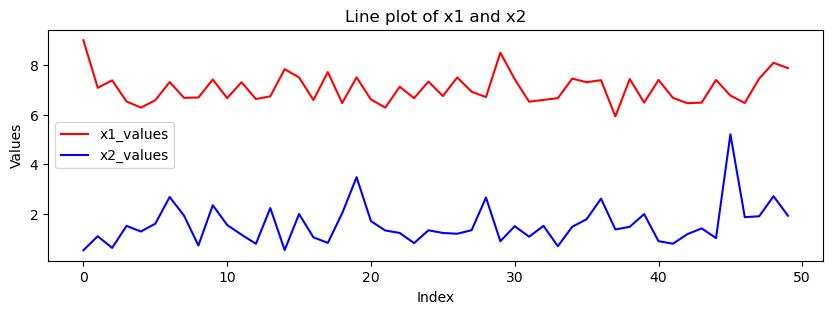

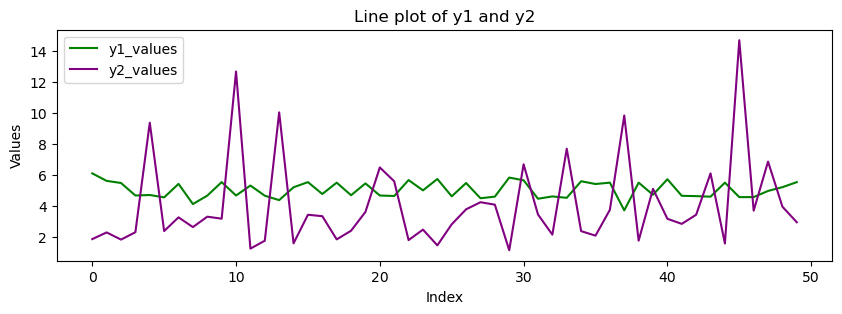

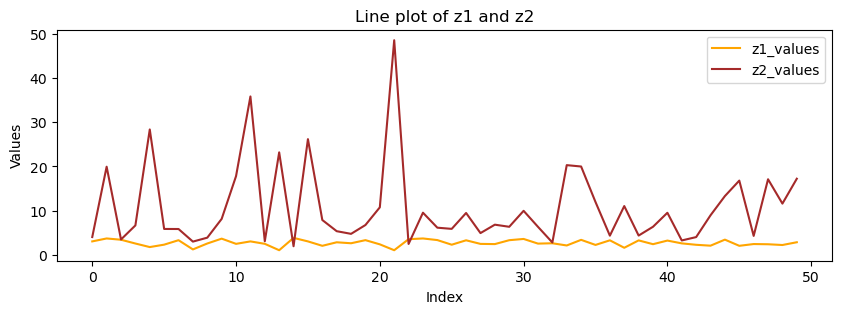

Percentage of PCD files with matching orders: 82.0%


In [267]:
def calculate_order_percentage(pcd_directory_path):
    matching_count = 0
    total_count = 0

    x1_values, y1_values, z1_values = [], [], []
    x2_values, y2_values, z2_values = [], [], []
    x3_values, y3_values, z3_values = [], [], []

    pcd_files = list(Path(pcd_directory_path).glob('*.pcd'))[:50]
    for pcd_file_path in pcd_files:
        czm = CZM(str(pcd_file_path))
        sectors, sector_indices = czm.segment_czm()
        images, image_sector_indices = czm.process_sectors(sectors)
        sorted_clusters, sector_cluster_mapping = czm.visualize_clusters(images, image_sector_indices, n_clusters=3, base_output_folder='output_clusters') # base_output_folder 추가
        mean_cluster_z_variances, cluster_residual_means= czm.calculate_cluster_z_variance(sectors, sector_cluster_mapping)

        # sorted_clusters와 mean_cluster_z_variances의 첫 번째 항목 추출
        sorted_clusters_order = [item[0] for item in sorted_clusters]
        sorted_clusters_order_2 = [item[1] for item in sorted_clusters]
        print(sorted_clusters_order)
        mean_cluster_order = [item[0] for item in mean_cluster_z_variances]
        mean_cluster_order_2 = [item[1] for item in mean_cluster_z_variances]
        print(mean_cluster_order)
        mean_residual_cluster_order = [item[0] for item in cluster_residual_means]
        mean_residual_cluster_order_2 = [item[1] for item in cluster_residual_means]

        x1_values.append(sorted_clusters_order_2[0])
        x2_values.append(mean_cluster_order_2[0])
        x3_values.append(mean_residual_cluster_order_2[0])
        y1_values.append(sorted_clusters_order_2[1])
        y2_values.append(mean_cluster_order_2[1])
        y3_values.append(mean_residual_cluster_order_2[1])
        z1_values.append(sorted_clusters_order_2[2])
        z2_values.append(mean_cluster_order_2[2])
        z3_values.append(mean_residual_cluster_order_2[2])



        if sorted_clusters_order == mean_cluster_order:
            matching_count += 1

        total_count += 1

    percentage = (matching_count / total_count) * 100

    correlation_x = np.corrcoef(x1_values, x2_values)[0, 1]
    print(f"Correlation between x1 and x2: {correlation_x}")

    correlation_y = np.corrcoef(y1_values, y2_values)[0, 1]
    print(f"Correlation between y1 and y2: {correlation_y}")

    correlation_z = np.corrcoef(z1_values, z2_values)[0, 1]
    print(f"Correlation between z1 and z2: {correlation_z}")

    plt.figure(figsize=(10, 3))

    plt.plot(x1_values, label='x1_values', color='red')
    plt.plot(x2_values, label='x2_values', color='blue')
    plt.title('Line plot of x1 and x2')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 3))
    plt.plot(y1_values, label='y1_values', color='green')
    plt.plot(y2_values, label='y2_values', color='purple')
    plt.title('Line plot of y1 and y2')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 3))
    plt.plot(z1_values, label='z1_values', color='orange')
    plt.plot(z2_values, label='z2_values', color='brown')
    plt.title('Line plot of z1 and z2')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.legend()
    plt.show()
    
    return x1_values, x2_values, y1_values, y2_values, z1_values, z2_values, percentage

pcd_directory_path = "/media/rtlink/JetsonSSD-256/Download/Rellis_3D_os1_cloud_node_color_ply/Rellis-3D/00000/os1_cloud_node_color_ply/pcd_files/"
x1_values, x2_values, y1_values, y2_values, z1_values, z2_values, percentage = calculate_order_percentage(pcd_directory_path)
print(f"Percentage of PCD files with matching orders: {percentage}%")


In [268]:
print(np.mean(x1_values))
print(np.mean(x2_values))
print(np.mean(y1_values))
print(np.mean(y2_values))
print(np.mean(z1_values))
print(np.mean(z2_values))

7.0525792427669565
1.567595438366299
5.025017580390747
4.038988178392288
2.6540545684199968
10.699700399344318
